# Install OpenVDS on Linux
##### **NOTE: Everything down to and including Cell 6 needs to be done once. After that you can just do `import openvds` within the same instance / kernel.**

Here we install OpenVDS+ from a pre-packaged Python Wheel and all its dependencies.

The copy of OpenVDS+ we have only works on 3.6 kernels. Let's check that first and throw error if its not.

Then find where the compiled libraries are located based on user's environment. Its either SageMaker or SageMaker Studio. The user directories are a little bit different between the two, so we handle that here.

In [1]:
from sys import version_info
major, minor, *rest = version_info
if major != 3 or minor !=6:
    raise SystemError(f"OpenVDS wheels currently work on Python 3.6. Your kernel is {major}.{minor}")

from os import path
user_dir = path.expanduser('~')

if not path.exists(path.join(user_dir, 'openvds_install')):
    user_dir = path.join(user_dir, 'SageMaker')

%pip install $user_dir/openvds_install/openvds-2.0.5-cp36-cp36m-linux_x86_64.whl

Processing /root/openvds_install/openvds-2.0.5-cp36-cp36m-linux_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


Let's try to import OpenVDS, and we get an error about the boost libraries missing.
**This is specific to Linux/SageMaker ONLY. On windows you won't get this error**

In [2]:
import openvds

ImportError: libboost_system.so.1.69.0: cannot open shared object file: No such file or directory

This error happens because OpenVDS depends on the boost libraries, and it is not installed by default on SageMaker instances.

We get the path to OpenVDS installation within site-packages in our environment.

We also get the boost-1.69, libssl, and libcrypto shared libraries we compiled from source and they are located in the `boost_lib` variable.

In [3]:
from os import path
import sysconfig

sitepkg_path = sysconfig.get_paths()["purelib"]

user_dir = path.expanduser('~')
if not path.exists(path.join(user_dir, 'openvds_install')):
    user_dir = path.join(user_dir, 'SageMaker')
    
boost_lib = path.join(user_dir, "openvds_install/boost_1_69_0_libs/*")

vds_lib_path = path.join(sitepkg_path, 'openvds')

print('Copy from:\t', boost_lib)
print('Copy to:\t', vds_lib_path)

Copy from:	 /root/openvds_install/boost_1_69_0_libs/*
Copy to:	 /usr/local/lib/python3.6/site-packages/openvds


Now we can run a copy `cp` command in shell that takes pre-compiled shared libraries to our site-packages environment so OpenVDS can use it.

In [4]:
!cp $boost_lib $vds_lib_path

On Red Hat Enterprise Linux (rhel) based Linux distributions, this is enough.

But some AWS instances are Ubuntu based, so OpenVDS has different dependencies for that. 

Here it tries to import OpenVDS (and it will succeed on rhel based systems) and move along. But if it fails (because it is Ubuntu distro), it will download the additional, required dependencies here.

On Ubuntu OpenVDS depends on: libcurl4 libuv1 libxml2 

On rhel 7 OpenVDS depends on: epel-release boost169-log boost169-random boost169-locale libuv libgomp python36

In [5]:
%%capture
# We capture output so notebook doesn't get flooded.
try:
    import openvds
except:
    !apt-get update
    !apt-get install -y libcurl4-openssl-dev libssh2-1 libuv1 libxml2

## ***Now we can finally import in both rhel and Ubuntu distros!***

From this point OpenVDS is installed on SageMaker Linux machine, we can do all the other things like querying, plotting etc.

In [6]:
import openvds

In [7]:
from os import getenv
from time import time

from vds_utils import (
    get_minicube,
    get_slice,
    print_channel_info,
    print_crs_metadata,
)

In [8]:
region = 'us-east-1'
region_config = f"Region={region}"

aws_config = ';'.join([
    region_config,
])

In [9]:
# Angle Stacks
# vds_url = r's3://sagemaker-gitc2021/poseidon/seismic/vds/psdn11_TbsdmF_Near_Nov_11_32bit/'
# vds_url = r's3://sagemaker-gitc2021/poseidon/seismic/vds/psdn11_TbsdmF_Mid_Nov_11_32bit/'
vds_url = r's3://sagemaker-gitc2021/poseidon/seismic/vds/psdn11_TbsdmF_Far_Nov_11_32bit/'

# Full Stack
# vds_url = r's3://sagemaker-gitc2021/poseidon/seismic/vds/psdn11_TbsdmF_full_w_AGC_Nov11/'

# Velocity Volume
# vds_url = r's3://sagemaker-gitc2021/poseidon/seismic/vds/Final_PSDM_intVel_gridded_D2T_10ms/'


vds_handle = openvds.open(
    url=vds_url,
    connectionString=aws_config,
)

layout = openvds.getLayout(vds_handle)

print_channel_info(layout)
print_crs_metadata(layout)

ChannelCount: 3
  Channel Name: Amplitude
    Value range: -15466.82421875 - 15466.82421875
  Channel Name: Trace
    Value range: 0.0 - 256.0
  Channel Name: SEGYTraceHeader
    Value range: 0.0 - 256.0
Dimensionality: 3
  Dimension name: Sample
    Number of samples: 1501
    Coordinate min max 0.0 - 6000.0
  Dimension name: Crossline
    Number of samples: 5053
    Coordinate min max 504.0 - 5556.0
  Dimension name: Inline
    Number of samples: 3437
    Coordinate min max 983.0 - 4419.0
SurveyCoordinateSystem::Origin: (409111.3543745714, 8429426.351163754)
SurveyCoordinateSystem::InlineSpacing: (12.052204947420725, 14.363266166298258)
SurveyCoordinateSystem::CrosslineSpacing: (-9.575551761678543, 8.034837688044338)


In [10]:
access_manager = openvds.VolumeDataAccessManager(vds_handle)

In [11]:
t0 = time()

il_range = (2550, 2650)
xl_range = (2950, 3050)
z_range = (2000, 4000)

mini_cube = get_minicube(
    access_manager=access_manager,
    layout=layout,
    il_range=il_range,
    xl_range=xl_range,
    z_range=z_range,
)

print(f"Retreived minicube in {time() - t0:.2f} seconds.")
print("Shape of minicube", mini_cube.shape)

Retreived minicube in 0.80 seconds.
Shape of minicube (101, 101, 501)


In [13]:
%%capture
!pip install matplotlib

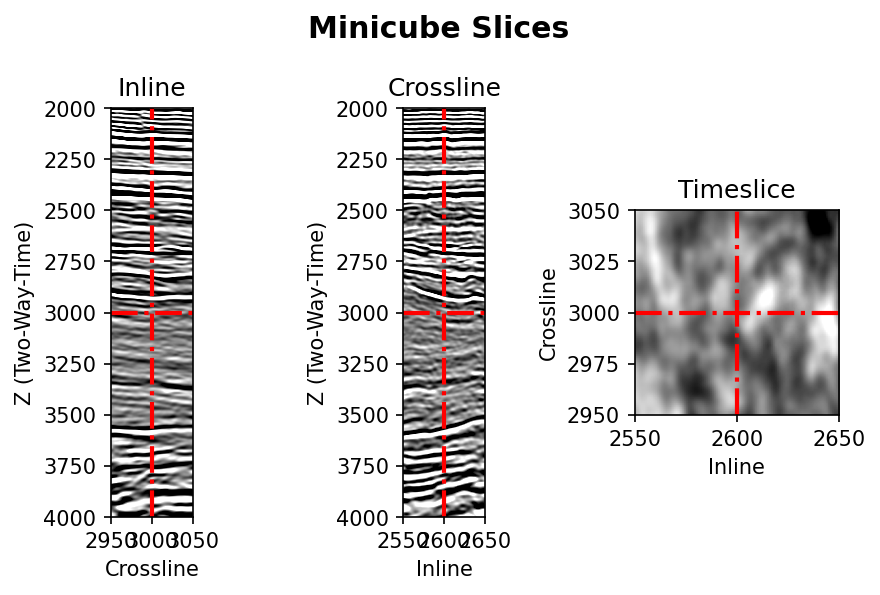

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax_il, ax_xl, ax_z) = plt.subplots(1, 3, dpi=150)

image_kwargs = {
    'vmin': -5250,
    'vmax': 5250,
    'cmap': 'gray',
}

line_kwargs = {
    'color': 'red',
    'linewidth': 2,
    'linestyle': '-.',
}

n_il, n_xl, n_z = mini_cube.shape
ax_il.imshow(mini_cube[n_il // 2, :, :].T, extent=[*xl_range, *z_range[::-1]], aspect=0.25, **image_kwargs)
ax_il.axvline(np.mean(xl_range), **line_kwargs)
ax_il.axhline(np.mean(z_range), **line_kwargs)
ax_il.set_xlabel('Crossline')
ax_il.set_ylabel('Z (Two-Way-Time)')
ax_il.set_title('Inline')

ax_xl.imshow(mini_cube[:, n_xl // 2, :].T, extent=[*il_range, *z_range[::-1]], aspect=0.25, **image_kwargs)
ax_xl.axvline(np.mean(il_range), **line_kwargs)
ax_xl.axhline(np.mean(z_range), **line_kwargs)
ax_xl.set_xlabel('Inline')
ax_xl.set_ylabel('Z (Two-Way-Time)')
ax_xl.set_title('Crossline')

ax_z.imshow(mini_cube[:, :, n_z // 2].T, extent=[*il_range, *xl_range], aspect=1, origin='lower', **image_kwargs)
ax_z.axhline(np.mean(xl_range), **line_kwargs)
ax_z.axvline(np.mean(il_range), **line_kwargs)
ax_z.set_xlabel('Inline')
ax_z.set_ylabel('Crossline')
ax_z.set_title('Timeslice')

fig.suptitle("Minicube Slices", size='x-large', weight='bold')
fig.tight_layout()

In [16]:
openvds.close(vds_handle)